# Deep Learning Course: Lab Exercises

In this lab exercise you will:

Learn about RNN and LSTM on toy sequential tasks:

Part 1: RNN and LSTM based 1D signal classifier & predictor

Part 2: RNN and LSTM based names classification with a character-level model

In [1]:
### Connect to Google Drive if you are using Drive.
from google.colab import drive

drive = drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# working folder
import os
working_dir = 'drive/MyDrive/FDL-Lab06'
os.chdir(working_dir)

In [3]:
### Import all your libraries
import random 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as data

import numpy as np 
from scipy import signal

from sklearn.metrics import f1_score

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Part 1: RNN and LSTM based 1D signal classifier & predictor

### 1.A. Data

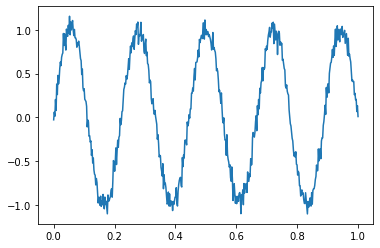

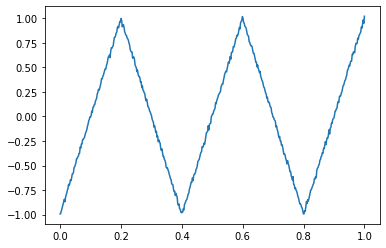

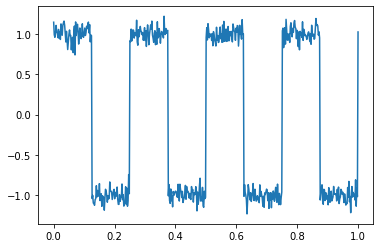

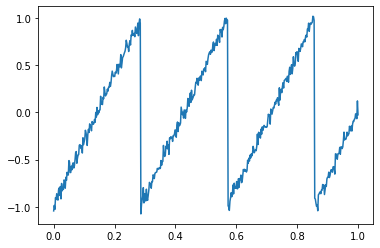

In [4]:
## Sine, Sawtooth, Tirangloe and Square wave generators
# *****START CODE
def get_noise():
    std = random.uniform(0, 0.1)
    noise = np.random.normal(0, std, 500)
    return noise

def get_sine():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    sine = np.sin(repeats * np.pi * time) + noise
    return time, sine

def get_triangle():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    triangle = signal.sawtooth(repeats * np.pi * time, 0.5) + noise
    return time, triangle

def get_square():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    square = signal.square(repeats * np.pi * time, 0.5) + noise
    return time, square

def get_sawtooth():
    noise = get_noise()
    time = np.linspace(0, 1, 500)
    repeats = random.randrange (5, 10)
    sawtooth = signal.sawtooth(repeats * np.pi * time) + noise
    return time, sawtooth
        
plt.plot(*get_sine())
plt.show()

plt.plot(*get_triangle())
plt.show()

plt.plot(*get_square())
plt.show()

plt.plot(*get_sawtooth())
plt.show()
# *****END CODE

### 1.B. RNN Wave Classification

In [5]:
## Dataloader 

class WavePreloader(data.Dataset):

    def __init__(self, samples=1000):
        self.samples = samples # Total samples to be generated in the dataset
        self.funcs = [get_sine, get_triangle, get_sawtooth, get_square] # functions to generate a sample

    def __getitem__(self, index):
        cls_lbl = random.randint(0, 3) # randomly get a function to generate
        _, inp = self.funcs[cls_lbl]() # generate wave
        
        return inp.reshape(-1, 1), cls_lbl # return generated wave and corresponding class label

    def __len__(self):
        return self.samples


In [6]:
## RNN classifier

class WaveClassifier(nn.Module):
    def __init__(self, n_classes=4):
        super(WaveClassifier, self).__init__()
        self.rnn = nn.RNN(input_size=1, 
                          hidden_size=8,
                          num_layers=1,
                          nonlinearity="relu",
                          batch_first=True)   # Define a 1 layer RNN which gives 8 dimensional feature map ouput
        self.linear = nn.Linear(8, n_classes)   # Define a linear layer that takes a vector of size 8 as input and gives num classes as ouput
        
    def forward(self, x):
        h0 = torch.randn(1, x.size()[0], 8).float() # create h0 tensor which has same size as input x
        x, hn = self.rnn(x, h0)  # forward pass through rnn
        x = self.linear(x[:,-1,:])  # apply linear layer to last time step of rnn output
        return x

In [7]:
## Instantiate dataloader, optimizer, loss, and network

lr = 0.01
batch_size = 100 
epochs = 10

train_dataset = WavePreloader(samples=2000)   # define training dataset
test_dataset = WavePreloader(samples=300)    # define test dataset

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)   # define train loader
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)     # define test loader

criterion = nn.CrossEntropyLoss()  # define a multi class loss 
model = WaveClassifier()           # instantiate your network
optimizer = optim.Adam(model.parameters(), lr=lr)   # instantiate your optimizer


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
## Train your network

for epoch in range(epochs):
    running_train_loss = []   # variable to accumulate losses
    running_test_loss = []
    
    train_predictions = []    # variable to accumulate predictions and ground truth labels
    train_ground_truths = []
    
    test_predictions = []
    test_ground_truths = []
    
    # train loop
    
    model.train()
    for inp_batch, lbl_batch in train_loader:
        model.zero_grad()
        
        inp_batch = Variable(inp_batch).float()
        lbl_batch = Variable(lbl_batch)
        
        pred = model(inp_batch)
        loss = criterion(pred, lbl_batch)
        loss.backward()
        optimizer.step()
    
        pred = torch.argmax(pred, dim=1)
        
        running_train_loss.append(loss.item())
        
        train_predictions += list(pred.data.numpy())
        train_ground_truths += list(lbl_batch.data.numpy())
    
    # test loop
    model.eval()
    for inp_batch, lbl_batch in test_loader:
        inp_batch = Variable(inp_batch).float()
        lbl_batch = Variable(lbl_batch)
        
        pred = model(inp_batch)
        loss = criterion(pred, lbl_batch)
    
        pred = torch.argmax(pred, dim=1)
        
        running_test_loss.append(loss.item())
        
        test_predictions += list(pred.data.numpy())
        test_ground_truths += list(lbl_batch.data.numpy())
      
    # print mean epoch loss and f1 score using accumulated loss and accumulated labels
    print (f"\n###### Epoch {epoch} ######")
    print ("Train Loss : ", np.mean(running_train_loss))
    print ("Train F1 Score : ", f1_score(train_ground_truths, train_predictions, average="macro"))
    
    print ("Test Loss : ", np.mean(running_test_loss))
    print ("Test F1 Score : ", f1_score(test_ground_truths, test_predictions, average="macro"))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 0 ######
Train Loss :  1.3406041145324707
Train F1 Score :  0.17762975458705
Test Loss :  1.2911232709884644
Test F1 Score :  0.21116637218332135


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 1 ######
Train Loss :  1.2114435672760009
Train F1 Score :  0.46037369030997555
Test Loss :  1.0883277257283528
Test F1 Score :  0.5583859353176979


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 2 ######
Train Loss :  0.9803563535213471
Train F1 Score :  0.5496019422643784
Test Loss :  0.8034741481145223
Test F1 Score :  0.5599836707615439


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 3 ######
Train Loss :  0.6932054132223129
Train F1 Score :  0.6471001671231942
Test Loss :  0.608341912428538
Test F1 Score :  0.6465264761012184


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 4 ######
Train Loss :  0.5574596643447876
Train F1 Score :  0.7028296537488463
Test Loss :  0.5055153667926788
Test F1 Score :  0.7185187939536011


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 5 ######
Train Loss :  0.5064385041594506
Train F1 Score :  0.6879688441597727
Test Loss :  0.47299812237421673
Test F1 Score :  0.7128205128205128


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 6 ######
Train Loss :  0.4521245062351227
Train F1 Score :  0.7295572252024924
Test Loss :  0.46942563851674396
Test F1 Score :  0.6629788079296459


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 7 ######
Train Loss :  473940.06443778274
Train F1 Score :  0.7741104108596149
Test Loss :  0.7826639811197916
Test F1 Score :  0.6664522215506687


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 8 ######
Train Loss :  0.9285425931215286
Train F1 Score :  0.5783363337054968
Test Loss :  0.9563520550727844
Test F1 Score :  0.5762211629713456


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 9 ######
Train Loss :  0.9975717723369598
Train F1 Score :  0.5481871711959913
Test Loss :  0.9704228043556213
Test F1 Score :  0.5398417435055366


### 1.C. LSTM Wave prediction


In [9]:
## Dataloader 

class WavePredPreloader(data.Dataset):

    def __init__(self, samples=1000):
        self.samples = samples # Total samples to be generated in the dataset
        self.funcs = [get_sine, get_triangle, get_sawtooth, get_square] # functions to generate a sample

    def __getitem__(self, index):
        cls_lbl = random.randint(0, 3) # randomly get a function to generate
        _, inp = self.funcs[cls_lbl]() # generate wave
        first_half = inp[:250]
        second_half = inp[250:]
        return first_half.reshape(-1, 1), second_half.reshape(-1, 1) # return generated wave split in half as input and label

    def __len__(self):
        return self.samples

In [10]:
## LSTM regressor

class WavePredictor(nn.Module):
    def __init__(self, n_classes=4):
        super(WavePredictor, self).__init__()
        self.lstm_in = nn.LSTM(input_size=1, 
                          hidden_size=8,
                          num_layers=1,
                          batch_first=True)   # Define a 1 layer LSTM which gives 8 dimensional feature map ouput
        self.lstm_out = nn.LSTM(input_size=8, 
                          hidden_size=1,
                          num_layers=1,
                          batch_first=True)   # Define a 1 layer LSTM which gives 8 dimensional input and 1 dimentionsnal ouput
        
    def forward(self, x):
        h0 = torch.randn(1, x.size()[0], 8).float() # create h0 tensor which has same size as input x
        c0 = torch.randn(1, x.size()[0], 8).float() # create c0 tensor which has same size as input x
        x, (hn, cn) = self.lstm_in(x, (h0, c0))
        
        h0 = torch.randn(1, x.size()[0], 1).float() # create h0 tensor which has same size as input x
        c0 = torch.randn(1, x.size()[0], 1).float() # create c0 tensor which has same size as input x
        x, (hn, cn) = self.lstm_out(x, (h0, c0))
        return x

In [11]:
## Instantiate dataloader, optimizer, loss, and network

lr = 0.0001
batch_size = 100
epochs = 10

train_dataset = WavePredPreloader(samples=2000)   # define training dataset
test_dataset = WavePredPreloader(samples=300)    # define test dataset

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)   # define train loader
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)     # define test loader

criterion = nn.MSELoss()  # define a MSE loss 
model = WavePredictor()           # instantiate your network
optimizer = optim.Adam(model.parameters(), lr=lr)   # instantiate your optimizer


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
## Train your network

for epoch in range(epochs):
    running_train_loss = []   # variable to accumulate losses
    running_test_loss = []
    
    
    # train loop
    
    model.train()
    for inp_batch, lbl_batch in train_loader:
        model.zero_grad()
        
        inp_batch = Variable(inp_batch).float()
        lbl_batch = Variable(lbl_batch).float()
        
        pred = model(inp_batch)
        loss = criterion(pred, lbl_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss.append(loss.item())
    
    # test loop
    model.eval()
    for inp_batch, lbl_batch in test_loader:
        inp_batch = Variable(inp_batch).float()
        lbl_batch = Variable(lbl_batch).float()
        
        pred = model(inp_batch)
        loss = criterion(pred, lbl_batch)
    
        
        running_test_loss.append(loss.item())
      
    # print mean epoch loss and f1 score using accumulated loss and accumulated labels
    print (f"\n###### Epoch {epoch} ######")
    print ("Train Loss : ", np.mean(running_train_loss))
    
    print ("Test Loss : ", np.mean(running_test_loss))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 0 ######
Train Loss :  0.5440404444932938
Test Loss :  0.5420862436294556

###### Epoch 1 ######
Train Loss :  0.5422861993312835
Test Loss :  0.5416762232780457

###### Epoch 2 ######
Train Loss :  0.537904055416584
Test Loss :  0.5539108117421468

###### Epoch 3 ######
Train Loss :  0.5372293129563331
Test Loss :  0.5455806652704874

###### Epoch 4 ######
Train Loss :  0.5366477489471435
Test Loss :  0.5559663971265157

###### Epoch 5 ######
Train Loss :  0.5395580857992173
Test Loss :  0.5681394139925638

###### Epoch 6 ######
Train Loss :  0.5336260557174682
Test Loss :  0.5665823817253113

###### Epoch 7 ######
Train Loss :  0.5428251385688782
Test Loss :  0.5447453459103903

###### Epoch 8 ######
Train Loss :  0.5452685609459877
Test Loss :  0.5285497506459554

###### Epoch 9 ######
Train Loss :  0.551257872581482
Test Loss :  0.5499409238497416


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


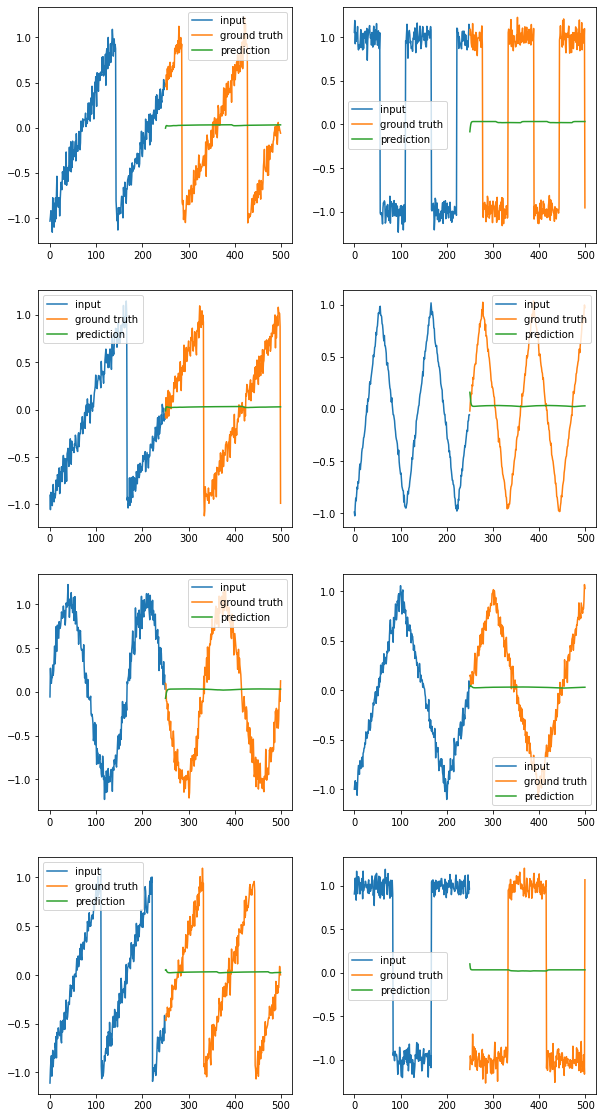

In [13]:
model.eval()
with torch.no_grad():
    inp_batch, lbl_batch = next(iter(test_loader))
    inp_batch = Variable(inp_batch).float()
    lbl_batch = Variable(lbl_batch).float()
    pred = model(inp_batch)

examples_to_show = 8
fig, axs = plt.subplots(examples_to_show//2, 2, figsize=(10,20))
for i in range(examples_to_show):
    axs[i//2, i%2].plot(np.arange(0,250,1), inp_batch.detach().numpy()[i])
    axs[i//2, i%2].plot(np.arange(250,500,1), lbl_batch.detach().numpy()[i])
    axs[i//2, i%2].plot(np.arange(250,500,1), pred.detach().numpy()[i])
    axs[i//2, i%2].legend(['input', 'ground truth', 'prediction'])

## Part 2: RNN and LSTM based names classification with a character-level model

### 2.A. Data

In [14]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/English.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Irish.txt', 'data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Vietnamese.txt']
Slusarski


In [15]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [16]:
names_data = []
max_length = 0
for category in category_lines.keys():
    lengths = [len(x) for x in category_lines[category]]
    if np.max(lengths)> max_length:
        max_length = np.max(lengths)
    names_data += [[x, category] for x in category_lines[category]]

In [17]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line, max_length=100):
    tensor = torch.zeros(max_length, n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([100, 57])


In [18]:
class NamesDataset(data.Dataset):
    def __init__(self, names_data, max_length=100):
        self.data = names_data
        self.max_length = max_length

    def __getitem__(self, index):
        line, category = self.data[index]
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line, max_length = self.max_length)
        return category, line, category_tensor, line_tensor

    def __len__(self):
        return len(self.data)

### 2.B. Name Classification 

In [19]:
class NameClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NameClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm_in = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)   
        self.lstm_out = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)  
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.randn(1, x.size()[0], self.hidden_size).float() 
        c0 = torch.randn(1, x.size()[0], self.hidden_size).float() 
        x, (hn, cn) = self.lstm_in(x, (h0, c0))
        
        h0 = torch.randn(1, x.size()[0], self.hidden_size).float() 
        c0 = torch.randn(1, x.size()[0], self.hidden_size).float() 
        x, (hn, cn) = self.lstm_out(x, (h0, c0))
        x = self.linear(x[:,-1,:]) 
        return x

In [20]:
## Instantiate dataloader, optimizer, loss, and network

n_hidden = 32
lr = 0.01
batch_size = 128
epochs = 25

random.shuffle(names_data)
train_dataset = NamesDataset(names_data[:-1000], max_length=max_length)   # define training dataset
test_dataset = NamesDataset(names_data[-1000:], max_length=max_length)    # define test dataset

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)   # define train loader
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)     # define test loader

model = NameClassifier(n_letters, n_hidden, n_categories)           # instantiate your network
optimizer = optim.Adam(model.parameters(), lr=lr)   # instantiate your optimizer
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
!pip install torchnet
import torchnet as tnt

# define confusion matrix using tnt package
confusion_matrix = tnt.meter.ConfusionMeter(n_categories)

     |████████████████████████████████| 676 kB 10.5 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=af339fbf027aa342d3104d603b63c751a7aff76ce54313b6eeb4f1161e3a3d56
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=ccabececf0759b07d349343fc6a1f33cf9a53f9b9d6e38503da39de3abdd2cdd
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=254784504bb139dd5afe63eed913f0310ff24456938106691ace782cee7d13d3
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchnet visdom torchfile


In [24]:
## Train your network

train_loss = []  
test_loss = []
for epoch in range(epochs):
    running_train_loss = []   # variable to accumulate losses
    running_test_loss = []
    
    
    # train loop
    model.train()
    for batch in train_loader:
        category, line, category_tensor, line_tensor = batch
        
        model.zero_grad()
        
        pred = model(line_tensor)
        loss = criterion(pred, torch.squeeze(category_tensor))
        loss.backward()
        optimizer.step()
        
        running_train_loss.append(loss.item())
    
    # test loop
    confusion_matrix.reset()
    model.eval()
    for batch in test_loader:
        category, line, category_tensor, line_tensor = batch

        pred = model(line_tensor)
        loss = criterion(pred, torch.squeeze(category_tensor))
        
        confusion_matrix.add(pred.data.squeeze(), torch.squeeze(category_tensor))
        running_test_loss.append(loss.item())
    
    # print mean epoch loss and f1 score using accumulated loss and accumulated labels
    print (f"\n###### Epoch {epoch} ######")
    train_loss.append(np.mean(running_train_loss))
    print ("Train Loss : ", np.mean(running_train_loss))
    test_loss.append(np.mean(running_test_loss))    
    print ("Val Loss : ", np.mean(running_test_loss))
    #print("Confusion Matrix:")
    #print(confusion_matrix.conf)
    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    print ("Val Acc : ", val_acc)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



###### Epoch 0 ######
Train Loss :  1.8820246569315593
Val Loss :  1.8706567287445068
Val Acc :  47.099999999999994

###### Epoch 1 ######
Train Loss :  1.852560518582662
Val Loss :  1.8668720424175262
Val Acc :  47.099999999999994

###### Epoch 2 ######
Train Loss :  1.851791621049245
Val Loss :  1.8650437742471695
Val Acc :  47.099999999999994

###### Epoch 3 ######
Train Loss :  1.8511867292722066
Val Loss :  1.863546758890152
Val Acc :  47.099999999999994


KeyboardInterrupt: ignored

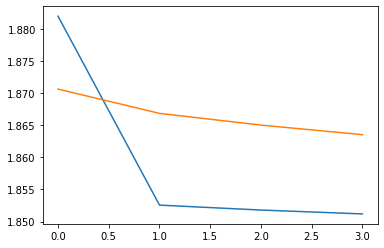

In [25]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)

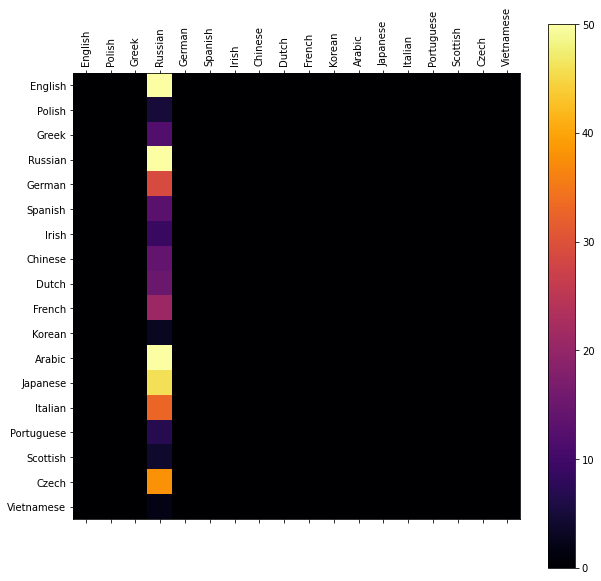

In [26]:
confusion = confusion_matrix.conf

# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap=plt.get_cmap('inferno'), vmax=50)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()